In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import scienceplots
%matplotlib inline

import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")

from scipy.interpolate import interp1d

import nanonets_utils
import nanonets

In [2]:
def plot_freq(f, ax, min_y, max_y, N_f=5):

    ax.vlines(f, min_y, max_y, colors='black', linestyles='solid', label=f"$f_0 = {f}$ GHz")

    for n in range(2,N_f+1):
        ax.vlines(n*f, min_y, max_y, colors='#A60628', linestyles='dotted')
    
    return ax

In [105]:
dic = {f : pd.read_csv(f"uniform/data/Nx=7_Ny=7_Nz=1_Ne=8_{f}.csv") for f in np.round(np.arange(0.3,4.1,0.1),2)}

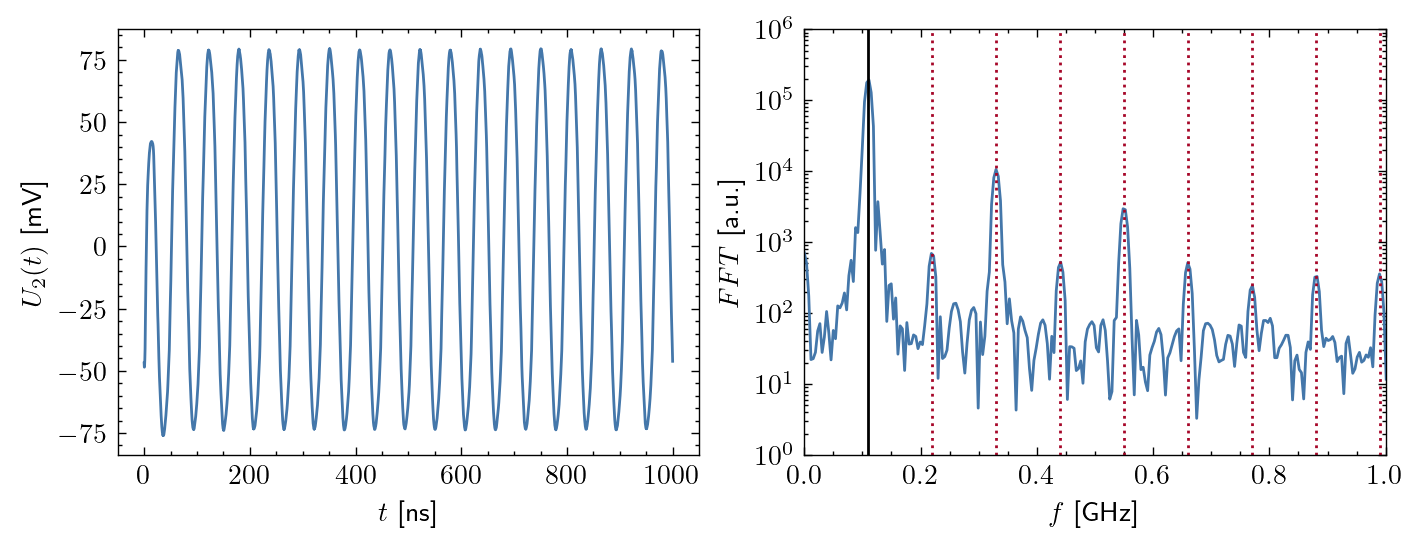

In [50]:
freq    = 1.1
elect   = 2
signal  = dic[freq][f'E{elect}']*1000
dt      = 1e-10
xf, yf  = nanonets_utils.fft(signal-np.mean(signal), dt, n_padded=16384)
time    = np.arange(len(signal))*dt*1e9
min_y   = 1
min_x   = 0
max_x   = 1
max_y   = 1e6

with plt.style.context(["science", "bright"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)

    ax = fig.add_subplot(1,2,1)
    ax.plot(time, signal)
    ax.set_ylabel("$U_{"+f"{elect}"+"}(t)$ [mV]")
    ax.set_xlabel("$t$ [ns]")
    # ax.set_ylim(-100,100)
    # ax.set_xlim(0,50)

    ax  = fig.add_subplot(1,2,2)
    ax.plot(xf,yf)
    ax  = plot_freq(freq/10, ax=ax, min_y=min_y, max_y=max_y, N_f=10)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_yscale('log')
    ax.set_xlabel("$f$ [GHz]")
    ax.set_ylabel("$FFT$ [a.u.]")

    fig.savefig("plots/fft_output_example.svg", transparent=True, bbox_inches='tight')

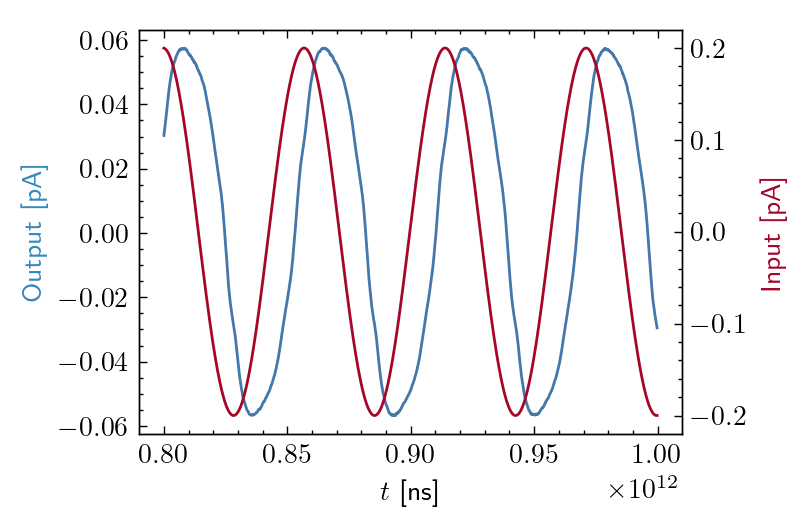

In [51]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax.plot(time[8000:]*1e9, dic[1.1]['Current'][8000:])
    ax2 = ax.twinx()
    ax2.plot(time[8000:]*1e9, dic[1.1]['E0'][8000:], nanonets_utils.red_color)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel('Output [pA]', c=nanonets_utils.blue_color)
    ax2.set_ylabel('Input [pA]', c=nanonets_utils.red_color)

    # fig.savefig("plots/I_O_example.svg", transparent=True)

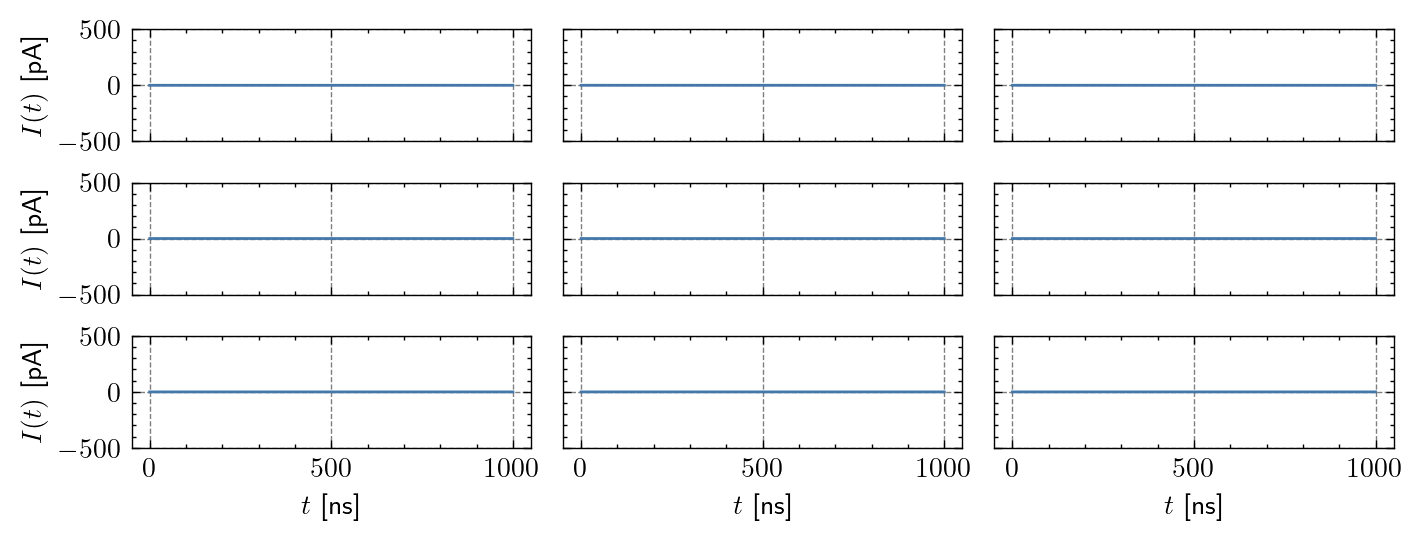

In [53]:
cmap    = plt.get_cmap('Reds')
f_vals  = np.round(np.arange(0.3,2,0.2),2)
miny    = 1e1
maxy    = 1e5
dt      = 1e-10
n_rows  = 3
n_cols  = 3

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    fig.set_figheight(fig.get_figheight()*1.2)
    
    for i, f in enumerate(f_vals):

        ax      = fig.add_subplot(4,3,i+1)
        signal  = dic[f]['Current'].values
        
        ax.plot(time,signal)

        if i % n_cols == 0:
            ax.set_ylabel('$I(t)$ [pA]')
        else:
            ax.set_yticklabels("")

        if i >= (n_rows-1)*3:
            ax.set_xlabel('$t$ [ns]')
        else:
            ax.set_xticklabels("")

        ax.set_ylim(-500,500)
        
    # fig.savefig("plots/output_comparsion.png", transparent=True, bbox_inches='tight')
    # fig.savefig("plots/output_comparsion.svg", transparent=True, bbox_inches='tight')

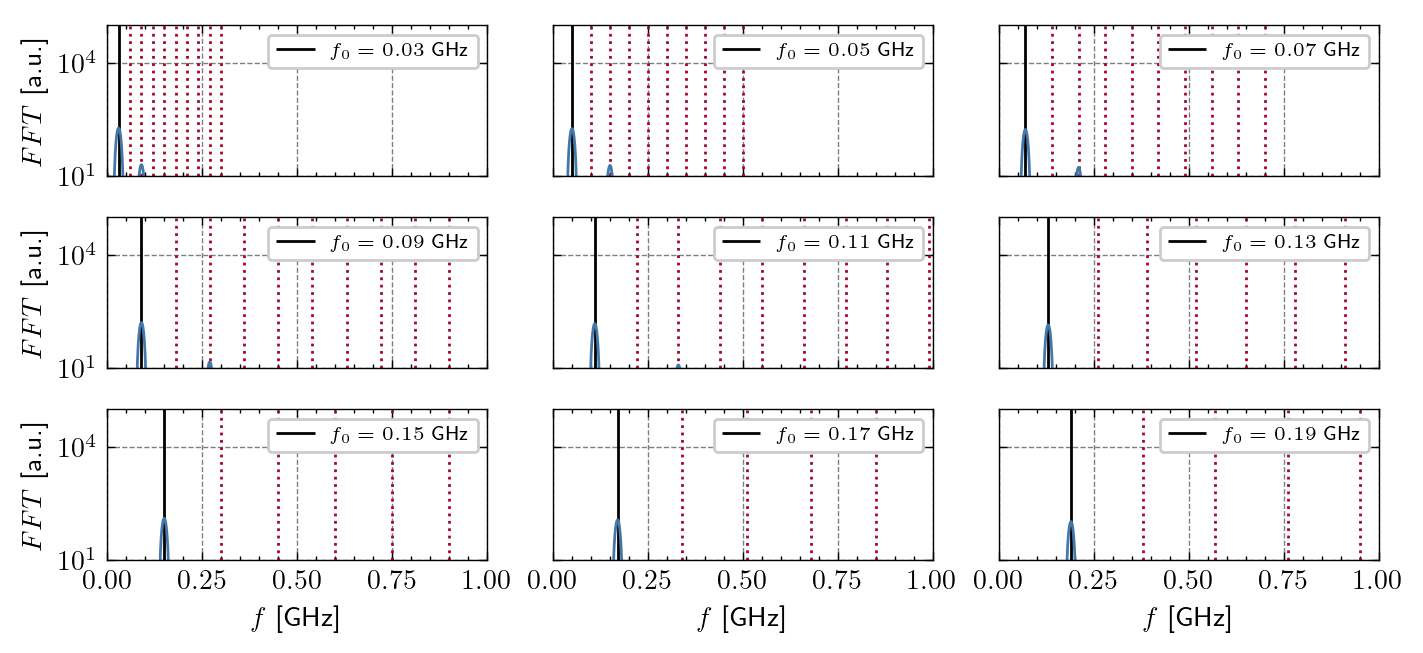

In [54]:
cmap    = plt.get_cmap('Reds')
miny    = 1e1
maxy    = 1e5
dt      = 1e-10
n_rows  = 3
n_cols  = 3

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    fig.set_figheight(fig.get_figheight()*1.2)
    
    for i, f in enumerate(f_vals):

        ax      = fig.add_subplot(n_rows,n_cols,i+1)
        signal  = dic[f]['Current'].values
        
        xf, yf  = nanonets_utils.fft(signal-np.mean(signal), dt, n_padded=65536)
        ax      = plot_freq(np.round(f/10,2), ax, miny, maxy, N_f=10)

        ax.plot(xf, yf)
        ax.set_xlim(0,1)
        ax.set_ylim(miny, maxy)
        ax.set_yscale('log')
        ax.legend(fontsize='x-small', loc='upper right')

        if i % n_cols == 0:
            ax.set_ylabel('$FFT$ [a.u.]')
        else:
            ax.set_yticklabels("")

        if i >= (n_rows-1)*3:
            ax.set_xlabel('$f$ [GHz]')
        else:
            ax.set_xticklabels("")

    # fig.savefig("plots/fft_comparsion.png", transparent=True, bbox_inches='tight')
    # fig.savefig("plots/fft_comparsion.svg", transparent=True, bbox_inches='tight')

In [106]:
def relate_to_fundamental_freq(signal, f, dt, N_f=10):

    xf, yf  = nanonets_utils.fft(signal, dt, n_padded=65536)
    func    = interp1d(xf, yf)

    vals    = []
    for n in range(1,N_f+1):
        vals.append(func(n*f/10))
    
    return np.array(vals)

In [127]:
N_f                 = 10
df_fft_amplitudes   = pd.DataFrame()
elect               = 1

for f in dic.keys():
    
    signal  = dic[f][f'E{elect}'].values
    vals    = relate_to_fundamental_freq(signal, f, dt, N_f=N_f)

    df_fft_amplitudes[f] = vals

df_nonlinear    = df_fft_amplitudes / df_fft_amplitudes.iloc[0,:]
df_nonlinear    = df_nonlinear.drop(0).reset_index(drop=True)
df_nonlinear

,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,...,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
0,0.005843,0.007511,0.007523,0.006507,0.006113,0.005407,0.004995,0.005226,0.005431,0.006091,...,0.002786,0.002007,0.001462,0.001129,0.000577,0.000827,0.001851,0.002188,0.002492,0.003397
1,0.051549,0.046143,0.039295,0.032934,0.028348,0.025750,0.023528,0.022124,0.021664,0.020989,...,0.044009,0.044990,0.045994,0.047511,0.047628,0.048708,0.049430,0.049759,0.050008,0.050479
2,0.005141,0.004677,0.003268,0.002129,0.002029,0.002326,0.003191,0.004047,0.004887,0.005614,...,0.001309,0.000732,0.000424,0.000418,0.000450,0.000347,0.000887,0.001461,0.001485,0.001653
3,0.010743,0.008329,0.010537,0.012863,0.014474,0.015599,0.016153,0.016349,0.015549,0.014339,...,0.022671,0.022445,0.022037,0.021684,0.021519,0.021065,0.020307,0.019842,0.019461,0.019340
4,0.003655,0.004900,0.004767,0.004044,0.003605,0.003381,0.003218,0.003248,0.003434,0.003529,...,0.000914,0.001053,0.001179,0.001147,0.001435,0.001451,0.001856,0.001674,0.001831,0.001954
5,0.002798,0.005002,0.006992,0.007849,0.007605,0.007236,0.006854,0.006693,0.006548,0.005998,...,0.010627,0.010342,0.010215,0.009599,0.009524,0.009030,0.008862,0.008426,0.008051,0.007532
6,0.004492,0.004847,0.004008,0.003605,0.003159,0.002521,0.002333,0.002264,0.002371,0.002446,...,0.000648,0.000744,0.000743,0.001015,0.001013,0.001058,0.001424,0.001229,0.001114,0.001224
7,0.003608,0.001243,0.002162,0.004296,0.005378,0.005646,0.004975,0.003970,0.002981,0.002053,...,0.006006,0.005930,0.005685,0.005685,0.005527,0.005294,0.005105,0.004982,0.004705,0.004630
8,0.003873,0.004606,0.003705,0.002842,0.002208,0.002028,0.001975,0.002086,0.002187,0.002205,...,0.000506,0.000336,0.000502,0.000397,0.000436,0.000695,0.000492,0.000579,0.000683,0.000345


In [128]:
df_nonlinear_new    = df_nonlinear.copy()
df_nonlinear_new    = df_nonlinear_new.set_index(np.arange(2,N_f+1))

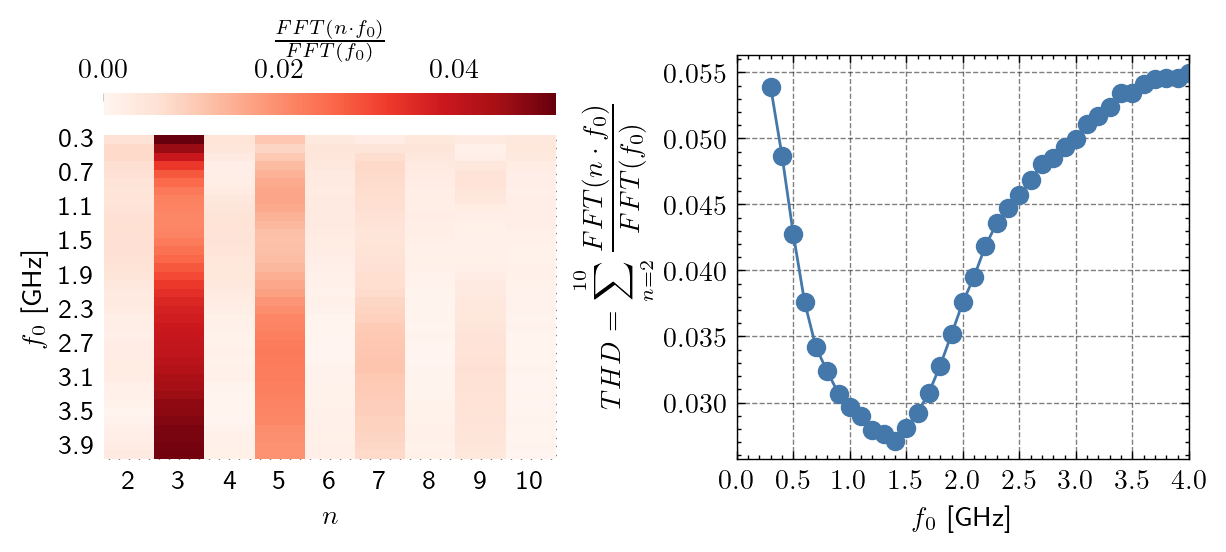

In [129]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot(1,2,1)
    fig.set_figwidth(fig.get_figwidth()*2)

    ax  = sns.heatmap(df_nonlinear_new.T, cmap='Reds', ax=ax, cbar_kws={'label':"$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$", "location":"top"}, vmin=0)
    ax.set_ylabel("$f_0$ [GHz]")
    ax.set_xlabel("$n$")

    # for i, col in enumerate(df_nonlinear.columns):
    #     ax.plot(np.arange(2,len(df_fft_amplitudes)+1), df_nonlinear[col], c=cmap((i+1)/(len(df_nonlinear.columns))))

    # ax.set_ylabel("$\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$")
    # ax.set_xlabel("$n$")

    ax  = fig.add_subplot(1,2,2)
    ax  = np.sqrt((df_nonlinear**2).sum()).plot(ax=ax, marker='o')
    ax.set_ylabel("$THD$ = $\displaystyle\sum_{n=2}^{10}\\frac{FFT(n \cdot f_0)}{FFT(f_0)}$")
    ax.set_xlabel("$f_0$ [GHz]")
    ax.set_xlim(0,4)

    plt.subplots_adjust(wspace=0.4)
    plt.locator_params(axis='x', nbins=8)

    # fig.savefig("plots/harmonic_generation.png", transparent=True, bbox_inches='tight')
    fig.savefig(f"plots/harmonic_generation_{elect}.svg", transparent=True, bbox_inches='tight')

In [130]:
amplitude       = 0.2
freq            = 1.5
step_size       = 1e-10
time            = step_size*np.arange(N_voltages)[1:]
n_cols          = 3
n_rows          = 2
f_vals          = [0.3, 0.7, 1.5, 3.5, 4.5, 5.5]
xmin            = [7000,8000,8800,9400,9500,9600]

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='constrained')

    for i, f in enumerate(f_vals):

        ax              = fig.add_subplot(n_rows,n_cols,i+1)
        ax2             = ax.twinx()
        input_signal    = amplitude*np.cos(f*time*1e8)
        signal          = dic[f]['Current'].values

        ax.plot(time[xmin[i]:], input_signal[xmin[i]:])
        ax2.plot(time[xmin[i]:], signal[xmin[i]:], c=nanonets_utils.red_color)

        # ax  = fig.add_subplot(4,2,(2+1)*i+1)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax2.set_yticklabels("")

        if i % n_cols == 0:
            ax.set_ylabel('$I$')

        if i >= (n_rows-1)*n_cols:
            ax.set_xlabel('$U$')

NameError: name 'N_voltages' is not defined

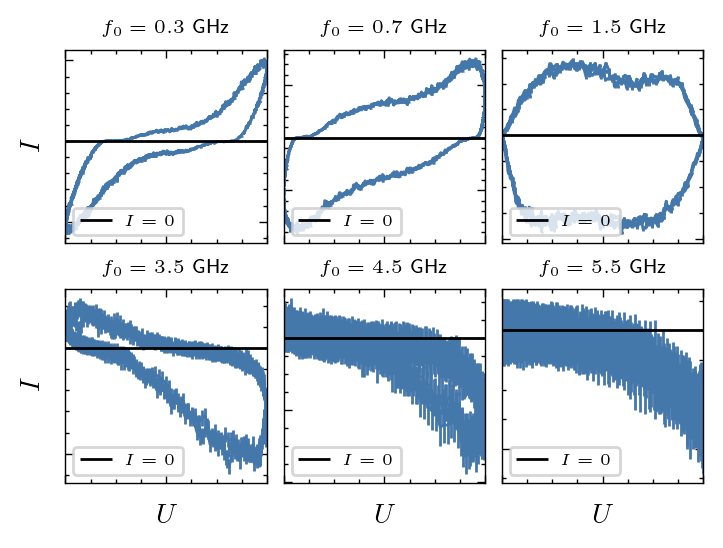

In [19]:
amplitude       = 0.2
freq            = 1.5
step_size       = 1e-10
time            = step_size*np.arange(len(signal))
n_cols          = 3
n_rows          = 2
f_vals          = [0.3, 0.7, 1.5, 3.5, 4.5, 5.5]
xmin            = [7000,8000,8800,9400,9500,9600]

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='constrained')

    for i, f in enumerate(f_vals):

        ax              = fig.add_subplot(n_rows,n_cols,i+1)
        input_signal    = amplitude*np.cos(f*time*1e8)
        signal          = dic[f]['Current'].values
        error           = dic[f]['Error'].values

        ax.errorbar(input_signal[xmin[i]:], signal[xmin[i]:], error[xmin[i]])
        ax.hlines(0,-0.2,0.2, 'black', zorder=10, label="$I = 0$")
        ax.set_xlim(-0.2,0.2)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.legend(fontsize='xx-small', loc='lower left', frameon=True)

        ax.set_title(f'$f_0 = {f}$ GHz', fontsize='x-small')

        if i % n_cols == 0:
            ax.set_ylabel('$I$')

        if i >= (n_rows-1)*n_cols:
            ax.set_xlabel('$U$')
    
    fig.savefig("plots/I_V_harmoic_generation.png", transparent=True, bbox_inches='tight')
    fig.savefig("plots/I_V_harmoic_generation.svg", transparent=True, bbox_inches='tight')

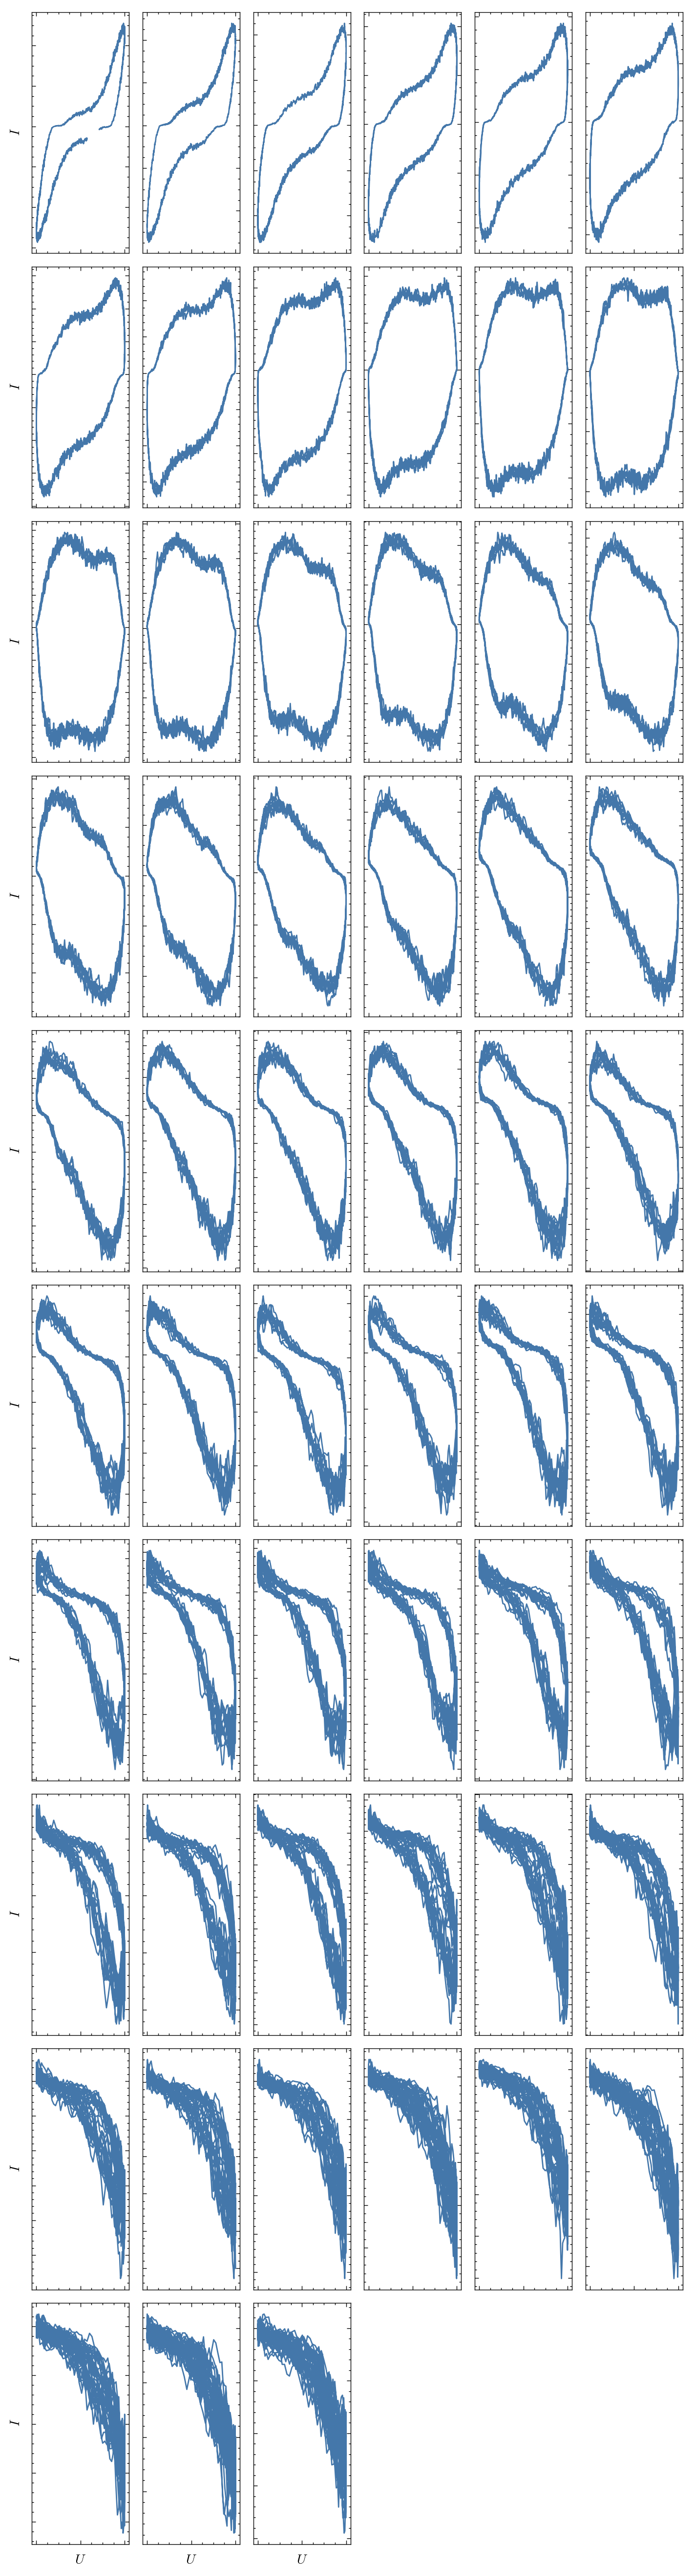

In [18]:
amplitude       = 0.2
freq            = 1.5
step_size       = 1e-10
time            = step_size*np.arange(len(signal))
n_cols          = 6
n_rows          = 10
f_vals          = [0.3, 1.5, 2.8, 4.5]
xmin            = 8000

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figheight(fig.get_figheight()*10)
    fig.set_figwidth(fig.get_figwidth()*2)

    for i, f in enumerate(dic.keys()):

        ax              = fig.add_subplot(n_rows,n_cols,i+1)
        input_signal    = amplitude*np.cos(f*time*1e8)
        signal          = dic[f]['Current'].values

        ax.plot(input_signal[xmin:], signal[xmin:])
        ax.set_xticklabels("")
        ax.set_yticklabels("")

        if i % n_cols == 0:
            ax.set_ylabel('$I$')

        if i >= (n_rows-1)*n_cols:
            ax.set_xlabel('$U$')

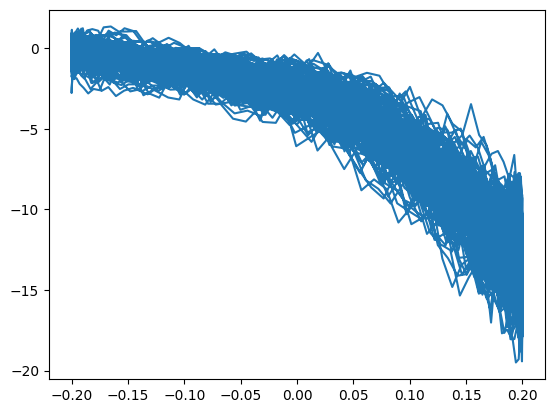

In [18]:
plt.plot(input_signal[800:], signal[800:])

---

### Charge Redistribtuion

In [19]:
dic_s = {f : pd.read_csv(f"uniform/data/mean_state_Nx=7_Ny=7_Nz=1_Ne=2_{f}.csv") for f in np.round(np.arange(0.3,6,0.1),2)}

for key, df in dic_s.items():

    dic_s[key].columns = np.arange(0,49)

In [20]:
def multiplot_observable_based_on_network(x_vals : pd.DataFrame, y_vals : pd.DataFrame, N : int,
                                          fig_scale=(1.5,1.5), x_lim=None, y_lim=None, y_label='y',
                                          x_label='x', log_x=False, log_y=False, style_context=["science","bright","grid"],
                                          x_full_range=False, y_full_range=False):
    
    if type(x_vals) == type(np.array([])):

        x_vals_new = pd.DataFrame()

        for col in y_vals.columns:

            x_vals_new[col] = x_vals
    
        x_vals = x_vals_new

    with plt.style.context(style_context):
        
        fig, axs    = plt.subplots(ncols=N, nrows=N, layout='constrained')
        width       = fig.get_figwidth()
        fig.set_figwidth(width*fig_scale[0])
        fig.set_figheight(width*fig_scale[1])

        if x_lim == None:
            x_lim = [x_vals.min().min(), x_vals.max().max()]

        if y_lim == None:
            y_lim = [y_vals.min().min(), y_vals.max().max()]

        i = 0

        for row in np.arange((N-1),-1,-1):
            
            for col in range(0,N):

                axs[row,col].plot(x_vals.loc[:,i], y_vals.loc[:,i])
                
                axs[row,col].set_xlim(x_lim[0],x_lim[1])
                axs[row,col].set_ylim(y_lim[0],y_lim[1])

                if i % N != 0:
                    axs[row,col].set_yticklabels("")
                else:    
                    axs[row,col].set_ylabel(y_label)

                if (i > N-1):
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel(x_label)

                if log_x:
                    axs[row,col].set_xscale('log')

                if log_y:
                    axs[row,col].set_yscale('log')

                if y_full_range:
                    axs[row,col].set_ylim(y_vals.loc[:,i].min(),y_vals.loc[:,i].max())
                    axs[row,col].set_yticklabels("")

                if x_full_range:
                    axs[row,col].set_xlim(x_vals.loc[:,i].min(),x_vals.loc[:,i].max())
                    axs[row,col].set_xticklabels("")

                i += 1

    return fig, axs

In [21]:
df_low          = dic_s[1.6].copy()
df_low.columns  = np.arange(0,49)
input_low       = amplitude*np.cos(1.6*time*1e8)
df_high         = dic_s[4.5].copy()
df_high.columns = np.arange(0,49)
input_high      = amplitude*np.cos(4.5*time*1e8)

(0.0, 1.5)

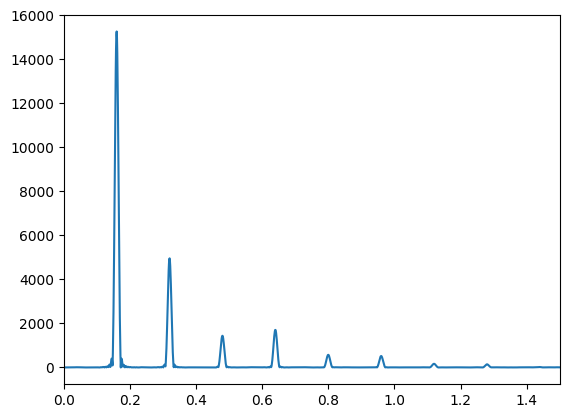

In [22]:
signal  = df_low[0].values
xf, yf  = nanonets_utils.fft(signal-np.mean(signal), dt, n_padded=65536)

plt.plot(xf, yf)
plt.xlim(0,1.5)

(900.0, 1000.0)

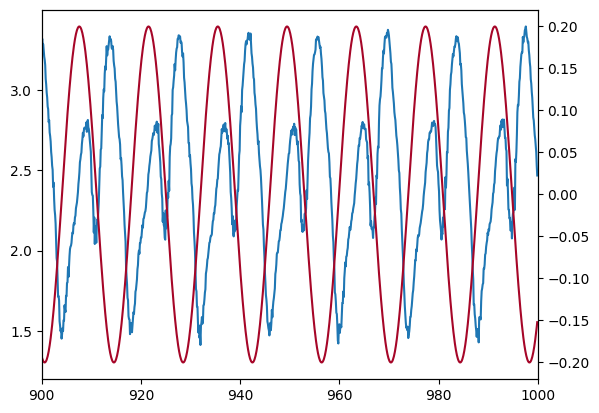

In [23]:
fig = plt.figure()
ax  = fig.add_subplot()
ax2 = ax.twinx()
ax.plot(time*1e9, df_high[6])
ax2.plot(time*1e9, input_high, nanonets_utils.red_color)
ax.set_xlim(900,1000)

In [24]:
def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

In [25]:
amplitude       = 0.2
input_signal    = amplitude*np.cos(freq*time*1e8)

Text(0.5, 0.98, '$f_0 = 1.6$ GHz')

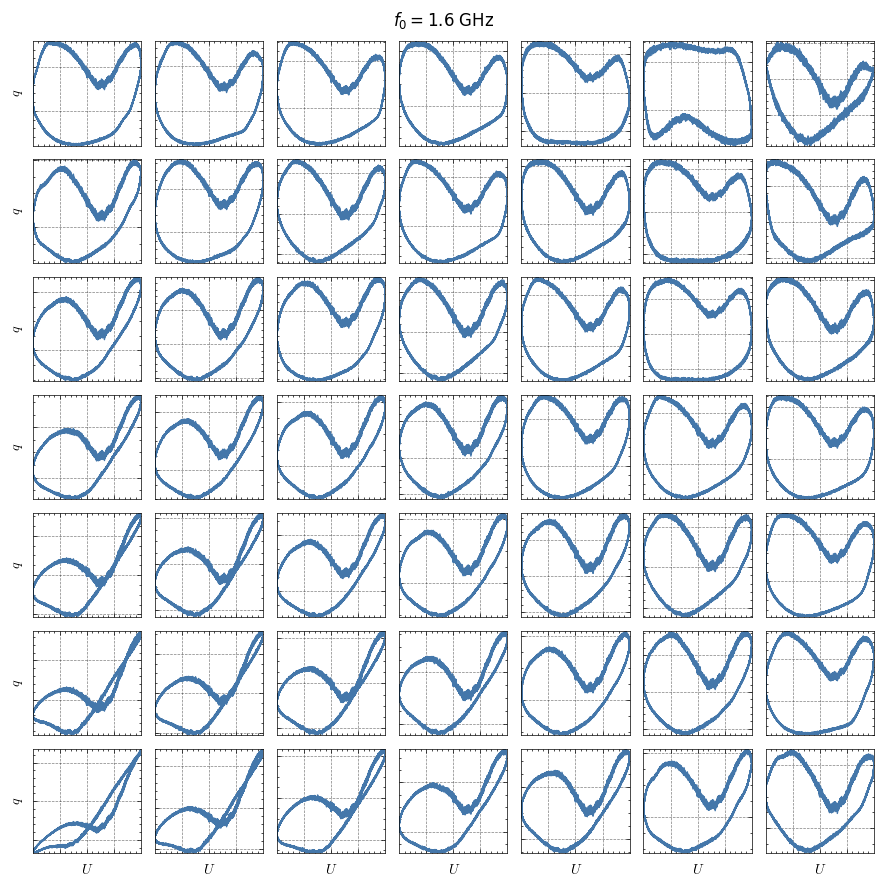

In [26]:
fig, ax = multiplot_observable_based_on_network(input_low[900:], df_low[900:], 7, fig_scale=(2.5,2.5),
                                                x_full_range=True, y_full_range=True, y_label="$q$", x_label="$U$") 
fig.suptitle("$f_0 = 1.6$ GHz")

Text(0.5, 0.98, '$f_0 = 4.8$ GHz')

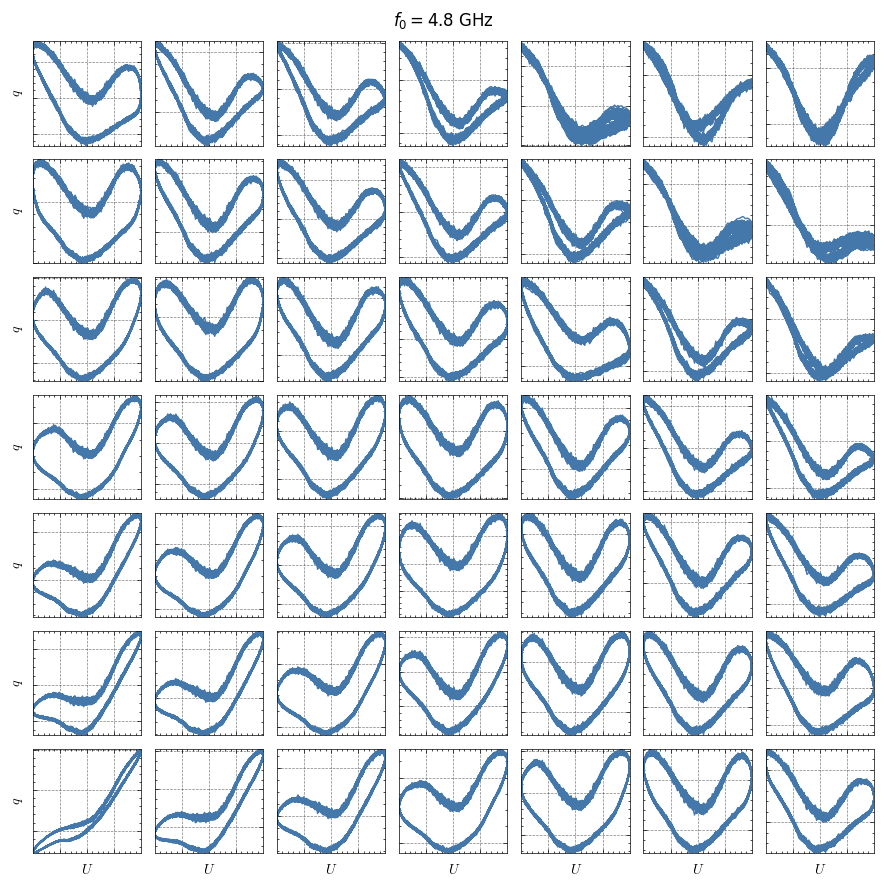

In [27]:
fig, ax = multiplot_observable_based_on_network(input_high[900:], df_high[900:], 7, fig_scale=(2.5,2.5),
                                                x_full_range=True, y_full_range=True, y_label="$q$", x_label="$U$") 
fig.suptitle("$f_0 = 4.8$ GHz")

Text(0.5, 0.98, '$f_0 = 4.8$ GHz')

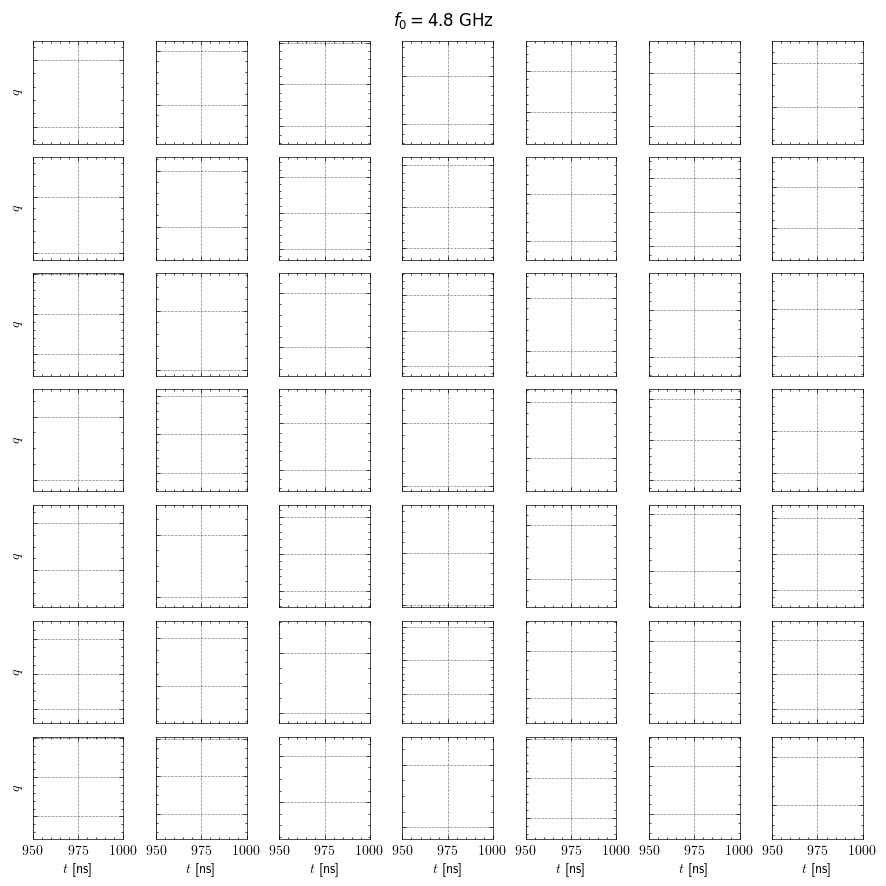

In [28]:
fig, ax = multiplot_observable_based_on_network(time, df_high, 7, fig_scale=(2.5,2.5), x_lim=(950,1000), y_lim=(-1,10),
                                                y_full_range=True, y_label="$q$", x_label="$t$ [ns]")
fig.suptitle("$f_0 = 4.8$ GHz")

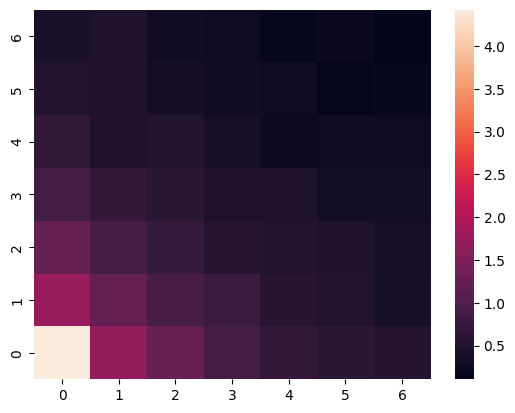

In [29]:
ax = sns.heatmap(np.reshape(df_high.std().values,(-1,7)))
ax.invert_yaxis()

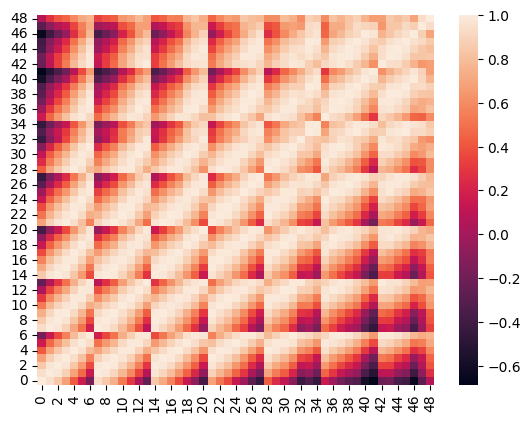

In [30]:
ax = sns.heatmap(df_high.corr())
ax.invert_yaxis()

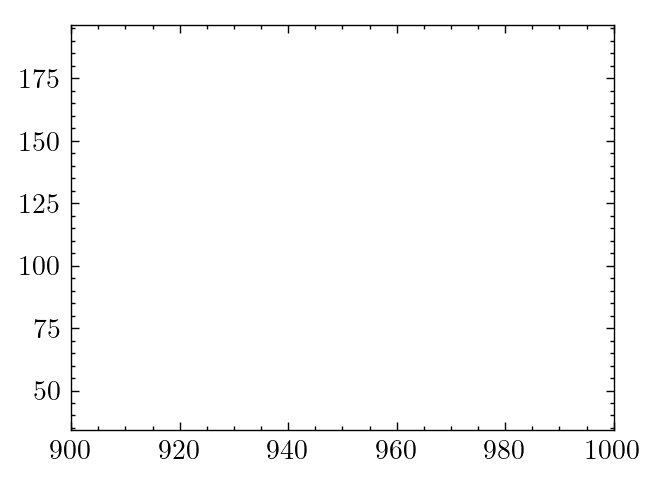

In [31]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    ax.plot(time, df_low.sum(axis=1))
    ax.plot(time, df_high.sum(axis=1))

    ax.set_xlim(900,1000)

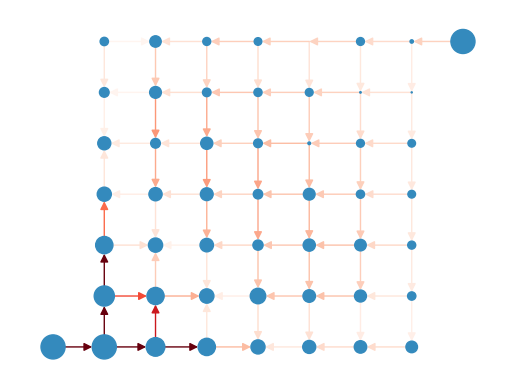

In [2]:
topology_parameter = {
    "Nx"    :   7,
    "Ny"    :   7,
    "Nz"    :   1,
    "e_pos" :   [[0,0,0],[6,6,0]]
}

sim_class   = nanonets.simulation('cubic', topology_parameter)
fig, ax     = nanonets_utils.display_network_currents(path="uniform/data/net_currents_Nx=7_Ny=7_Nz=1_Ne=2_4.5.csv", row=[900,1000],
                                                      N_electrodes=2, pos=sim_class.pos, charge_landscape=True, arrow_scale=1, edge_vmin=0, edge_vmax=0.1)

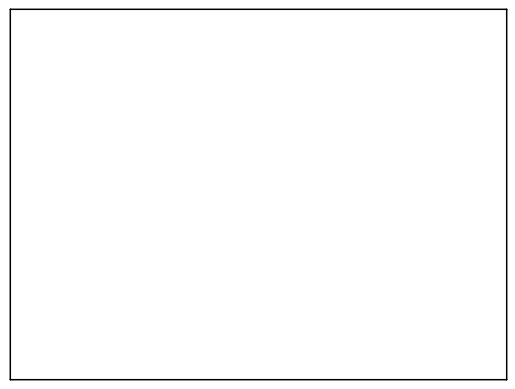

In [40]:
ims = []

for i in range(10):

    if i == 0:
        fig = None

    sim_class   = nanonets.simulation('cubic', topology_parameter)
    fig, ax     = nanonets_utils.display_network_currents(path="uniform/data/net_currents_Nx=7_Ny=7_Nz=1_Ne=2_4.5.csv", row=i,
                                                        N_electrodes=2, pos=sim_class.pos, charge_landscape=True, arrow_scale=1,
                                                        edge_vmin=0, edge_vmax=0.1, fig=fig)
    im  = ax.get_children().copy()
    ims.append(im)
    # fig.clear()
    # ax.clear()

In [41]:
# sim_class   = nanonets.simulation('cubic', topology_parameter)
# fig, ax     = nanonets_utils.display_network_currents(path="uniform/data/net_currents_Nx=7_Ny=7_Nz=1_Ne=2_4.5.csv", row=0,
#                                                         N_electrodes=2, pos=sim_class.pos, charge_landscape=True, arrow_scale=1,
#                                                         edge_vmin=0, edge_vmax=0.1, fig=fig)
ani         = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
ani.save("hi.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


---

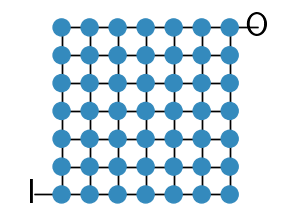

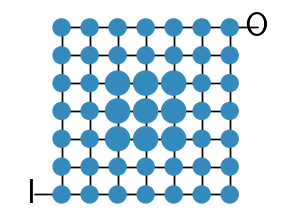

In [37]:
node_size = 150

sim_class   = nanonets.simulation('cubic', topology_parameter)
fig, ax     = nanonets_utils.display_network(np_network_sim=sim_class, node_size=node_size, provide_electrode_labels=["I","O"], font_size=25)
# fig.savefig('plots/network_plot.svg', bbox_inches='tight', transparent=True)
# fig.savefig('plots/network_plot.pdf', bbox_inches='tight', transparent=False)

node_size = np.repeat(150, 51)

for i in [16,17,18,23,24,25,30,31,32]:
    node_size[i] = 300

sim_class   = nanonets.simulation('cubic', topology_parameter)
fig, ax     = nanonets_utils.display_network(np_network_sim=sim_class, node_size=node_size, provide_electrode_labels=["I","O"], font_size=25)
# fig.savefig('plots/network_plot_radius.svg', bbox_inches='tight', transparent=True)
# fig.savefig('plots/network_plot_radius.pdf', bbox_inches='tight', transparent=False)